In [1]:
from multiprocessing import Pool
from pathlib import Path

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

import numpy as np

Using TensorFlow backend.


In [2]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [3]:
IMAGES_DIR = Path('/home/superdell/Pictures/fabryka_memes/fabrykamemow_memes/')
images_paths = list(IMAGES_DIR.iterdir())

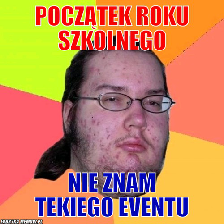

In [4]:
img = image.load_img(images_paths[4], target_size=(224, 224))
img

In [5]:
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

model.predict(img_data).flatten()

array([0.       , 0.       , 0.       , ..., 0.       , 1.8566287,
       0.       ], dtype=float32)

In [6]:
def get_image_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    return model.predict(img_data).flatten()

In [7]:
np.random.seed(420)
rand_images = np.random.choice(images_paths, 5000)

In [8]:
def load_image_to_array(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    return preprocess_input(img_data)
    

def load_images_in_array_format(images_paths_list):    
    with Pool() as pool:
        images = pool.map(load_image_to_array, images_paths_list)
        
    return np.array(images)

In [9]:
img_data = load_images_in_array_format(rand_images)
features = model.predict(img_data)
features = features.reshape((len(rand_images), -1))

In [10]:
def get_similarity_scores(base_point, target_points, dist_type='euclidean'):
    if dist_type == 'cosine':
        return cosine_similarity([base_point], target_points)[0]
    elif dist_type == 'euclidean':
        scores = euclidean_distances([base_point], target_points)[0]
        return 1 - scores / scores.sum()
    else:
        raise NotImplementedError(f"{dist_type} metric is not implemented")


In [46]:
DIM = 128

pca = PCA(n_components=DIM)
features_lower_dim = pca.fit_transform(features)

In [47]:
def show_similar_memes(base_img_path, top_n):
    img = image.load_img(base_img_path, target_size=(224, 224))
    
    print("Base image")
    display(img)
    
    img_features = get_image_features(base_img_path)
    features_pca = pca.transform([img_features])[0]
    
    scores = get_similarity_scores(features_pca, features_lower_dim, dist_type='cosine')
    
    images_by_scores = sorted(zip(rand_images, scores), key=lambda a: a[1], reverse=True)
    top_n_images_scores = images_by_scores[1:top_n + 1]
    
    print("Similar images:")

    for img_path, score in top_n_images_scores:
        img = image.load_img(img_path, target_size=(224, 224))
        
        display(score)
        display(img)

Base image


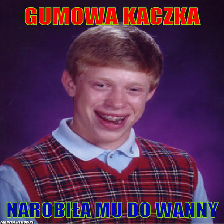

Similar images:


0.99022645

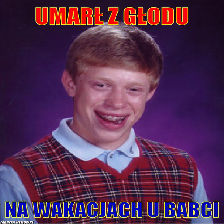

0.9853249

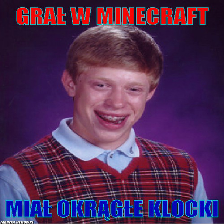

0.98463404

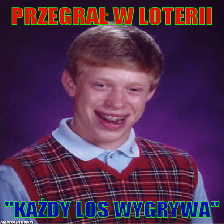

0.9845328

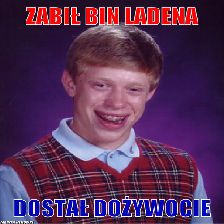

0.9840321

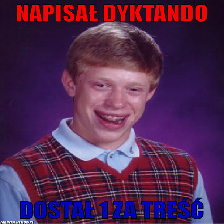

In [58]:
chosen_image = 2
img_path = rand_images[chosen_image]

show_similar_memes(img_path, 5)